In [1]:
### Read in Existing Product CSV File
library(readr)
#exst_prod <- read_csv("~/RStudioDocs/course2task2/New_Products_Analysis_Data/existing product attributes.csv",col_names=TRUE)
library(pastecs)

Loading required package: boot


In [2]:
## This identifies outliers which are within a specified number of standard deviations
## around the mean. The defaul is 3 SD's. Therefore, with the default, the outliers will 
## be defined as 1.5 SD above and below the mean

findOutlier <- function(data,cols, cutoff = 3) {
    ## 
    tmp = data
    for (i in colnames(tmp)) {
        ## IF the column is not in the list
        if (!is.element(i, cols) ) {
            tmp[i]<-NULL
        }
    }
    
    ## Calculate the sd
    sds <- apply(tmp, 2, sd, na.rm = TRUE)
    ## Calculate the mean
    smn <- apply(tmp, 2, mean, na.rm = TRUE)
    ## Identify the cells with outside the specified range
    result <- mapply(function(d, s,m) {
        which((d > (cutoff/2 * s)+m) | (d < m- (cutoff/2 * s)))
    }, tmp, sds,smn)
    
    return(result)
}

In [3]:
## This identifies outliers which are within a specified number of standard deviations
## around the mean. The defaul is 3 SD's. Therefore, with the default, the outliers will 
## be defined as 1.5 SD above and below the mean

findOutlier <- function(data,colnames, cutoff = 3) {
    ## Calculate the sd
    sds <- apply(data, 2, sd, na.rm = TRUE)
    ## Calculate the mean
    smn <- apply(data, 2, mean, na.rm = TRUE)
    ## Identify the cells with outside the specified range
    result <- mapply(function(d, s,m) {
        which((d > (cutoff/2 * s)+m) | (d < m- (cutoff/2 * s)))
    }, data, sds,smn)
    return(result)
}

In [4]:
## This function takes outliers and assigns the value NA
removeOutlier <- function(data, outliers) {
    result <- mapply(function(d, o) {
        res <- d
        res[o] <- NA
        return(res)
    }, data, outliers)
    return(as.data.frame(result))
}

In [5]:
## Function - update one column name
update_one_colname <- function(df,old_col, new_col) {
  result <- df # make a copy of the input data frame
  pos<- which(colnames(result)==old_col)
  colnames(result)[pos] <- new_col
  return(result)
}

In [6]:
## Function for one-hot-encoding

one_hot_encod <- function(df,cols) {
  result <- df # make a copy of the input data frame
  
  for (j in cols) { # each specified col
    print(j)
    ## Make all NA's a character value
    df[j][is.na(df[j])] <- "~NAN~" 
    ## Model matrix will denormalize the column       
    result=with(df,data.frame(model.matrix(~unlist(df[j])-1,df)))
    print("Column names from result")
    print(colnames(result))
      
    for (k in colnames(result)) {
      ## The following is the string to be replaced
      match_str <-"unlist.df.j.."
      ## Use gsub to get the new column string with the 'unlist...' removed
      ##    and replace with column name 'j' from the outer for loop
      new_col_str <- gsub(match_str,j, k)
      ## Call function to update column name
      result <- update_one_colname(result,k,new_col_str)        
    }
    df=cbind(df,result)
    ## Delete column that was normalized
    df[j]<-NULL
  }
    
  print(colnames(df))

  
  return(df)
  
}

In [7]:
## Normalize the dataframe
normalize_df <- function(df,cols) {
    result <- df  # Make a copy of the input data frame
    for (i in cols) {
        colmin = min(result[i],na.rm=TRUE)
        colmax = max(result[i],na.rm=TRUE)
        
        for (j in 1:nrow(result)) {
            result[j,i]<-(result[j,i]-colmin)/(colmax-colmin)
        }
    }
    return(result)
}

In [8]:
## Drop columns that will be ommitted from analysis
drop_col <- function(df,cols) {
    result <- df
    for (i in cols){
        result[i] <-NULL
    }
    return(result)
}

In [9]:
## Get index
df_index <- read_csv("train/train.csv")[ ,1:1]

Parsed with column specification:
cols(
  .default = col_integer(),
  VAR_0001 = col_character(),
  VAR_0005 = col_character(),
  VAR_0008 = col_character(),
  VAR_0009 = col_character(),
  VAR_0010 = col_character(),
  VAR_0011 = col_character(),
  VAR_0012 = col_character(),
  VAR_0043 = col_character(),
  VAR_0044 = col_character(),
  VAR_0073 = col_character(),
  VAR_0075 = col_character(),
  VAR_0156 = col_character(),
  VAR_0157 = col_character(),
  VAR_0158 = col_character(),
  VAR_0159 = col_character(),
  VAR_0166 = col_character(),
  VAR_0167 = col_character(),
  VAR_0168 = col_character(),
  VAR_0169 = col_character(),
  VAR_0176 = col_character()
  # ... with 45 more columns
)
See spec(...) for full column specifications.


In [10]:
head(df_index)

ID
2
4
5
7
8
14


In [11]:
df_target <- read_csv("train/train.csv")[ ,1934:1934]

Parsed with column specification:
cols(
  .default = col_integer(),
  VAR_0001 = col_character(),
  VAR_0005 = col_character(),
  VAR_0008 = col_character(),
  VAR_0009 = col_character(),
  VAR_0010 = col_character(),
  VAR_0011 = col_character(),
  VAR_0012 = col_character(),
  VAR_0043 = col_character(),
  VAR_0044 = col_character(),
  VAR_0073 = col_character(),
  VAR_0075 = col_character(),
  VAR_0156 = col_character(),
  VAR_0157 = col_character(),
  VAR_0158 = col_character(),
  VAR_0159 = col_character(),
  VAR_0166 = col_character(),
  VAR_0167 = col_character(),
  VAR_0168 = col_character(),
  VAR_0169 = col_character(),
  VAR_0176 = col_character()
  # ... with 45 more columns
)
See spec(...) for full column specifications.


In [12]:
df_target<-cbind(df_index,df_target)

In [13]:
## Make rownames equal to ID
rownames(df_target) <- df_target$ID
## Drop ID Column
df_target$ID <- NULL

In [14]:
head(df_target)

,target
2,0
4,0
5,0
7,0
8,1
14,0


In [15]:
## Load first 10 columns of train.csv file
df <- read_csv("train/train.csv")[ ,2:10]

Parsed with column specification:
cols(
  .default = col_integer(),
  VAR_0001 = col_character(),
  VAR_0005 = col_character(),
  VAR_0008 = col_character(),
  VAR_0009 = col_character(),
  VAR_0010 = col_character(),
  VAR_0011 = col_character(),
  VAR_0012 = col_character(),
  VAR_0043 = col_character(),
  VAR_0044 = col_character(),
  VAR_0073 = col_character(),
  VAR_0075 = col_character(),
  VAR_0156 = col_character(),
  VAR_0157 = col_character(),
  VAR_0158 = col_character(),
  VAR_0159 = col_character(),
  VAR_0166 = col_character(),
  VAR_0167 = col_character(),
  VAR_0168 = col_character(),
  VAR_0169 = col_character(),
  VAR_0176 = col_character()
  # ... with 45 more columns
)
See spec(...) for full column specifications.


In [16]:
## Drop ID Column
df$ID <- NULL

In [17]:
## Combine index and df
df<-cbind(df_index,df)

In [18]:
## Make rownames equal to ID
row.names(df) <- df$ID
## Drop ID Column
df$ID <- NULL

In [19]:
## 
(head(df))

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009
2,H,224,0,4300,C,0,0,false,false
4,H,7,53,4448,B,1,0,false,false
5,H,116,3,3464,C,0,0,false,false
7,H,240,300,3200,C,0,0,false,false
8,R,72,261,2000,N,0,0,false,false
14,R,4,4,4422,C,0,0,false,false


In [20]:
## Backed up the df in case we need to start over
bkup_df = df
## Restore

In [21]:
## Capture samples of the full data set in order to run more quickly while developing
set.seed(123)
sample_indices <- sample(seq_len(nrow(df)),size=5000)

In [22]:
df <- df[sample_indices,]

In [23]:
df_target <- df_target[sample_indices,]
df_index <- df_index[sample_indices,]

In [24]:
## Inspect structure
str(df)

'data.frame':	5000 obs. of  9 variables:
 $ VAR_0001: chr  "R" "R" "R" "R" ...
 $ VAR_0002: int  326 57 74 18 204 261 43 9 276 195 ...
 $ VAR_0003: int  36 167 13 4 263 0 43 48 25 147 ...
 $ VAR_0004: int  1090 1627 1100 1428 3906 0 2159 1783 2000 3897 ...
 $ VAR_0005: chr  "C" "B" "N" "S" ...
 $ VAR_0006: int  1 0 0 8 0 0 0 3 3 0 ...
 $ VAR_0007: int  1 0 0 5 0 0 0 1 3 0 ...
 $ VAR_0008: chr  "false" "false" "false" "false" ...
 $ VAR_0009: chr  "false" "false" "false" "false" ...


In [25]:
length(t(unique(df["VAR_0001"])))

[1] 3

In [26]:
## Check for the number of unique values for each of the 'character' columns

max_unique_vals <-5  # Set maximum unique values for 'object' columns
                        # We don't want to create too many normalized columns
df_ohe_list =list()  # Prepare list for one-hot-encoding
df_drop_list=list()  # Prepare list for columns to drop
df_nrm_list=list()  # Prepare list for columns to find outliers and normalize
for (i in colnames(df)) {
    # Check if column is of type character
    if (sapply(df[i], class)=='character') {
        ## Check number of unique values - if greater than allowed max or if only one value, put in drop list
        
        if (length(t(unique(df[i]))) > max_unique_vals|length(t(unique(df[i]))) == 1) {
            df_drop_list <- c(df_drop_list,i)            
        } else {
            ## If not greater than max # of unique values, then put in One Hot Encoding list
            df_ohe_list <- c(df_ohe_list,i)          
        }        
    }  else {
        ## Add to list of columns to normalize
        df_nrm_list <- c(df_nrm_list,i)
    }  
}

In [27]:
df_nrm_list

[[1]]
[1] "VAR_0002"

[[2]]
[1] "VAR_0003"

[[3]]
[1] "VAR_0004"

[[4]]
[1] "VAR_0006"

[[5]]
[1] "VAR_0007"

In [28]:
df_drop_list

[[1]]
[1] "VAR_0008"

[[2]]
[1] "VAR_0009"

In [29]:
df_ohe_list

[[1]]
[1] "VAR_0001"

[[2]]
[1] "VAR_0005"

In [30]:
## Restore from backup if needed
##df <-bkup_df

In [31]:
head(df)

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009
83368,R,326,36,1090,C,1,1,false,false
228926,R,57,167,1627,B,0,0,false,false
118798,R,74,13,1100,N,0,0,false,false
256313,R,18,4,1428,S,8,5,false,false
273035,H,204,263,3906,B,0,0,false,false
13003,H,261,0,0,N,0,0,false,false


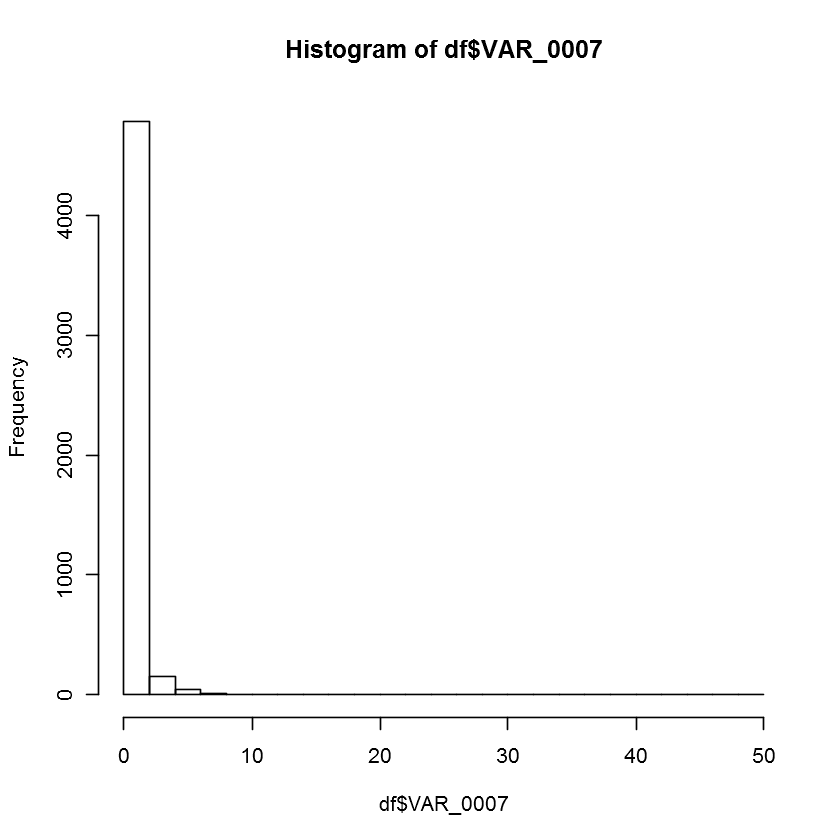

In [32]:
## Look at histogram
#hist(df$VAR_00070
hist(df$VAR_0007, breaks=20)

In [33]:
#Denormalize character columns with one-hot-encoding
df <- one_hot_encod(df,df_ohe_list)

[1] "VAR_0001"
[1] "Column names from result"
[1] "unlist.df.j..H" "unlist.df.j..Q" "unlist.df.j..R"
[1] "VAR_0005"
[1] "Column names from result"
[1] "unlist.df.j..B" "unlist.df.j..C" "unlist.df.j..N" "unlist.df.j..S"
 [1] "VAR_0002"  "VAR_0003"  "VAR_0004"  "VAR_0006"  "VAR_0007"  "VAR_0008" 
 [7] "VAR_0009"  "VAR_0001H" "VAR_0001Q" "VAR_0001R" "VAR_0005B" "VAR_0005C"
[13] "VAR_0005N" "VAR_0005S"


In [34]:
## Show dataframe statistics after one-hot-encoding
stat.desc(df) 

,VAR_0002,VAR_0003,VAR_0004,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0001H,VAR_0001Q,VAR_0001R,VAR_0005B,VAR_0005C,VAR_0005N,VAR_0005S
nbr.val,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,NA,NA,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
nbr.null,2.500000e+01,6.230000e+02,1.100000e+02,3.480000e+03,3.522000e+03,NA,NA,2.881000e+03,4.980000e+03,2.139000e+03,2.486000e+03,3.206000e+03,4.409000e+03,4.899000e+03
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.990000e+02,9.990000e+02,2.000000e+05,1.900000e+01,4.900000e+01,NA,NA,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
range,9.990000e+02,9.990000e+02,2.000000e+05,1.900000e+01,4.900000e+01,NA,NA,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
sum,5.369680e+05,4.476040e+05,1.781912e+07,3.320000e+03,2.523000e+03,NA,NA,2.119000e+03,2.000000e+01,2.861000e+03,2.514000e+03,1.794000e+03,5.910000e+02,1.010000e+02
median,6.100000e+01,5.700000e+01,2.500000e+03,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
mean,1.073936e+02,8.952080e+01,3.563824e+03,6.640000e-01,5.046000e-01,NA,NA,4.238000e-01,4.000000e-03,5.722000e-01,5.028000e-01,3.588000e-01,1.182000e-01,2.020000e-02
SE.mean,2.059855e+00,1.831560e+00,9.338943e+01,2.121299e-02,1.876343e-02,NA,NA,6.989169e-03,8.927258e-04,6.997659e-03,7.071664e-03,6.783931e-03,4.566171e-03,1.989770e-03


In [35]:
## Show dataframe statistics after one-hot-encoding
stat.desc(df) 

,VAR_0002,VAR_0003,VAR_0004,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0001H,VAR_0001Q,VAR_0001R,VAR_0005B,VAR_0005C,VAR_0005N,VAR_0005S
nbr.val,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,NA,NA,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
nbr.null,2.500000e+01,6.230000e+02,1.100000e+02,3.480000e+03,3.522000e+03,NA,NA,2.881000e+03,4.980000e+03,2.139000e+03,2.486000e+03,3.206000e+03,4.409000e+03,4.899000e+03
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.990000e+02,9.990000e+02,2.000000e+05,1.900000e+01,4.900000e+01,NA,NA,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
range,9.990000e+02,9.990000e+02,2.000000e+05,1.900000e+01,4.900000e+01,NA,NA,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
sum,5.369680e+05,4.476040e+05,1.781912e+07,3.320000e+03,2.523000e+03,NA,NA,2.119000e+03,2.000000e+01,2.861000e+03,2.514000e+03,1.794000e+03,5.910000e+02,1.010000e+02
median,6.100000e+01,5.700000e+01,2.500000e+03,0.000000e+00,0.000000e+00,NA,NA,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
mean,1.073936e+02,8.952080e+01,3.563824e+03,6.640000e-01,5.046000e-01,NA,NA,4.238000e-01,4.000000e-03,5.722000e-01,5.028000e-01,3.588000e-01,1.182000e-01,2.020000e-02
SE.mean,2.059855e+00,1.831560e+00,9.338943e+01,2.121299e-02,1.876343e-02,NA,NA,6.989169e-03,8.927258e-04,6.997659e-03,7.071664e-03,6.783931e-03,4.566171e-03,1.989770e-03


In [36]:
## Drop columns from DF
df=drop_col(df,df_drop_list)

In [37]:
## Get list of outliers
outliers <- findOutlier(df,df_nrm_list,cutoff=4)

In [38]:
df[1:10,]

,VAR_0002,VAR_0003,VAR_0004,VAR_0006,VAR_0007,VAR_0001H,VAR_0001Q,VAR_0001R,VAR_0005B,VAR_0005C,VAR_0005N,VAR_0005S
83368,326,36,1090,1,1,0,0,1,0,1,0,0
228926,57,167,1627,0,0,0,0,1,1,0,0,0
118798,74,13,1100,0,0,0,0,1,0,0,1,0
256313,18,4,1428,8,5,0,0,1,0,0,0,1
273035,204,263,3906,0,0,1,0,0,1,0,0,0
13003,261,0,0,0,0,1,0,0,0,0,1,0
153592,43,43,2159,0,0,0,0,1,1,0,0,0
259131,9,48,1783,3,1,0,0,1,0,0,1,0
160453,276,25,2000,3,3,1,0,0,1,0,0,0
132502,195,147,3897,0,0,1,0,0,1,0,0,0


In [39]:
## Show outliers
outliers

$VAR_0002
  [1]   75  108  112  159  208  216  226  236  321  396  430  450  453  503  510
 [16]  531  556  597  643  656  697  702  708  723  792  805  808  825  832  844
 [31]  856  872  873  917  923  931  936  945  973 1120 1133 1152 1159 1165 1237
 [46] 1238 1296 1342 1344 1385 1402 1437 1438 1471 1472 1479 1496 1558 1567 1576
 [61] 1605 1621 1638 1681 1696 1700 1721 1763 1769 1774 1779 1796 1862 1893 1946
 [76] 1970 2002 2023 2028 2029 2049 2062 2099 2119 2122 2174 2198 2208 2210 2259
 [91] 2289 2339 2341 2427 2436 2507 2511 2593 2627 2681 2708 2761 2781 2819 2844
[106] 2877 2920 2933 2959 2982 2988 3029 3047 3070 3101 3145 3171 3196 3202 3203
[121] 3296 3360 3380 3404 3410 3421 3424 3469 3513 3533 3534 3539 3546 3548 3571
[136] 3591 3617 3619 3634 3658 3673 3704 3716 3719 3736 3806 3814 3856 3880 3896
[151] 3898 3905 3912 3936 3947 3972 4021 4032 4055 4056 4082 4097 4113 4124 4130
[166] 4172 4279 4284 4331 4339 4341 4364 4371 4411 4414 4416 4423 4432 4439 4447
[181] 4474 4495 4520 4531 4532 4566 4598 4624 4628 4695 4744 4773 4800 4806 4834
[196] 4838 4942

$VAR_0003
  [1]   19   48   76   98  125  143  161  219  249  281  376  455  470  488  497
 [16]  599  639  656  681  684  840  850  857  882 1098 1120 1137 1198 1214 1234
 [31] 1238 1242 1317 1408 1426 1453 1456 1480 1611 1763 1769 1869 1888 1893 1897
 [46] 1931 1995 2011 2016 2023 2029 2039 2097 2229 2236 2248 2317 2319 2364 2424
 [61] 2427 2437 2444 2465 2485 2573 2584 2605 2627 2632 2641 2675 2679 2702 2720
 [76] 2761 2819 2822 2833 2898 2905 3003 3005 3013 3017 3030 3053 3067 3082 3094
 [91] 3096 3198 3219 3260 3306 3323 3347 3380 3411 3443 3532 3541 3546 3668 3719
[106] 3725 3736 3750 3776 3816 3870 3978 3987 4020 4032 4045 4067 4088 4106 4137
[121] 4159 4167 4173 4208 4225 4268 4309 4318 4374 4408 4425 4474 4495 4531 4615
[136] 4638 4655 4747 4793 4825 4841 4866 4901 4918 4952 4980 4994 4998

$VAR_0004
 [1]  180  279  310  331  416  461  484  488  501  509  567  608  619  645  668
[16]  671  780  833 1100 1141 1153 1206 1360 1420 1460 1486 1542 1658 1705 1724
[31] 1876 1877 1928 1982 2005 2290 2372 2427 2443 2526 2550 2639 2686 2690 2735
[46] 2781 2810 2921 2942 2947 2972 2978 3106 3159 3221 3343 3363 3369 3428 3519
[61] 3539 3607 3613 3857 3862 3915 3928 3930 3983 4242 4313 4317 4348 4390 4420
[76] 4474 4555 4605 4618 4722 4736 4778 4877 4948 4981

$VAR_0006
  [1]    4   54  148  153  154  186  193  221  251  259  360  365  385  434  439
 [16]  461  466  489  494  547  563  566  571  578  599  602  668  701  703  710
 [31]  711  721  728  737  739  773  793  822  831  879  908  910  941 1006 1017
 [46] 1044 1068 1075 1088 1137 1239 1253 1259 1262 1295 1297 1300 1303 1315 1318
 [61] 1340 1341 1352 1358 1364 1367 1378 1389 1445 1489 1498 1501 1514 1524 1536
 [76] 1564 1601 1604 1615 1686 1733 1747 1774 1800 1808 1824 1865 1880 1883 1936
 [91] 1951 1995 2065 2095 2132 2140 2156 2163 2171 2181 2217 2229 2268 2298 2327
[106] 2329 2359 2363 2372 2385 2396 2402 2434 2442 2443 2452 2475 2530 2547 2570
[121] 2571 2577 2609 2614 2616 2624 2633 2668 2693 2716 2718 2727 2743 2747 2816
[136] 2818 2832 2850 2854 2862 2953 2959 2967 3004 3028 3065 3082 3134 3142 3162
[151] 3168 3169 3185 3195 3219 3241 3294 3356 3405 3424 3427 3435 3437 3442 3443
[166] 3454 3480 3483 3506 3509 3580 3595 3599 3634 3779 3807 3810 3837 3849 3853
[181] 3941 3949 3968 3990 4021 4031 4037 4068 4070 4081 4083 4103 4107 4113 4118
[196] 4124 4140 4144 4170 4175 4180 4216 4231 4247 4249 4259 4290 4327 4341 4351
[211] 4367 4387 4405 4416 4427 4448 4515 4540 4547 4609 4613 4655 4698 4708 4745
[226] 4760 4817 4826 4857 4864 4948 4969

$VAR_0007
  [1]    4  159  186  220  221  372  385  394  429  461  466  489  547  566  620
 [16]  721  819  822  890  926  941 1017 1034 1075 1169 1190 1224 1258 1259 1364
 [31] 1445 1498 1501 1514 1601 1800 1848 2065 2229 2355 2357 2372 2442 2452 2475
 [46] 2530 2547 2577 2624 2654 2716 2719 2734 2743 2772 2832 2959 2995 3004 3082
 [61] 3142 3149 3195 3206 3241 3294 3354 3

In [40]:
df[75:85,]

,VAR_0002,VAR_0003,VAR_0004,VAR_0006,VAR_0007,VAR_0001H,VAR_0001Q,VAR_0001R,VAR_0005B,VAR_0005C,VAR_0005N,VAR_0005S
137905,999,14,3200,0,0,0,0,1,1,0,0,0
63614,12,999,2708,0,0,1,0,0,0,1,0,0
110264,168,72,3500,1,2,0,0,1,0,1,0,0
177766,246,270,2821,0,0,1,0,0,1,0,0,0
102090,93,92,3473,3,1,1,0,0,0,1,0,0
32025,5,36,3000,0,0,1,0,0,0,1,0,0
70471,99,0,1200,0,0,0,0,1,1,0,0,0
193792,46,134,4513,0,0,1,0,0,1,0,0,0
121203,115,18,3500,0,0,1,0,0,1,0,0,0
228777,61,0,1600,0,0,1,0,0,1,0,0,0


In [41]:
## Assign NA to outlier values
df <- removeOutlier(df, outliers)

In [42]:
##
str(df)

'data.frame':	5000 obs. of  12 variables:
 $ VAR_0002 : num  326 57 74 18 204 261 43 9 276 195 ...
 $ VAR_0003 : num  36 167 13 4 263 0 43 48 25 147 ...
 $ VAR_0004 : num  1090 1627 1100 1428 3906 ...
 $ VAR_0006 : num  1 0 0 NA 0 0 0 3 3 0 ...
 $ VAR_0007 : num  1 0 0 NA 0 0 0 1 3 0 ...
 $ VAR_0001H: num  0 0 0 0 1 1 0 0 1 1 ...
 $ VAR_0001Q: num  0 0 0 0 0 0 0 0 0 0 ...
 $ VAR_0001R: num  1 1 1 1 0 0 1 1 0 0 ...
 $ VAR_0005B: num  0 1 0 0 1 0 1 0 1 1 ...
 $ VAR_0005C: num  1 0 0 0 0 0 0 0 0 0 ...
 $ VAR_0005N: num  0 0 NA 0 0 NA 0 NA 0 0 ...
 $ VAR_0005S: num  0 0 0 NA 0 0 0 0 0 0 ...


In [43]:
##
df <- normalize_df(df,df_nrm_list)

In [44]:
t(head(df))

,1,2,3,4,5,6
VAR_0002,0.8190955,0.1432161,0.18592965,0.04522613,0.5125628,0.6557789
VAR_0003,0.1034483,0.4798851,0.03735632,0.01149425,0.7557471,0.0000000
VAR_0004,0.0681250,0.1016875,0.06875000,0.08925000,0.2441250,0.0000000
VAR_0006,0.3333333,0.0000000,0.00000000,NA,0.0000000,0.0000000
VAR_0007,0.3333333,0.0000000,0.00000000,NA,0.0000000,0.0000000
VAR_0001H,0.0000000,0.0000000,0.00000000,0.00000000,1.0000000,1.0000000
VAR_0001Q,0.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000
VAR_0001R,1.0000000,1.0000000,1.00000000,1.00000000,0.0000000,0.0000000
VAR_0005B,0.0000000,1.0000000,0.00000000,0.00000000,1.0000000,0.0000000
VAR_0005C,1.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000
